# Formative Assessment 8
## One-way ANOVA (1B)

**General Instructions: Do a complete data analysis for PlantGrowth in {datasets} package in R using a one-way ANOVA (1B) and provide a complete report in APA style.**

To obtain and extract `PlantGrowth.csv` file from RStudio, we will execute this code:

`write.csv(PlantGrowth, "C:/Users/YourUsername/Documents/PlantGrowth.csv", row.names = FALSE)`

### Step 1: Import Necessary Libraries and Load Data

In [1]:
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

### Dataset `PlantGrowth.csv` and the Problem (Part 1)
> In this study, we investigate whether plant growth is influenced by different treatments. 

> We know plants can respond variably to environmental or chemical treatments, and understanding these differences can aid in agricultural optimization. 

> To further explore this, 30 plants were divided into three groups: "control" (ctrl), "treatment 1" (trt1), and "treatment 2" (trt2), each representing a different treatment condition.

In [10]:
# Load out the dataset
data = pd.read_csv('/kaggle/input/plantgrowth/plantgrowth.csv')
print("**Here is the preview of the entire dataset**")
data

**Here is the preview of the entire dataset**


,weight,group
0,4.17,ctrl
1,5.58,ctrl
2,5.18,ctrl
3,6.11,ctrl
4,4.50,ctrl
5,4.61,ctrl
6,5.17,ctrl
7,4.53,ctrl
8,5.33,ctrl
9,5.14,ctrl


## Introduction to One-Way ANOVA

Unlike Independent Sample T-Tests, some researches may establish **ONE-WAY ANALYSIS OF VARIANCE (ANOVA)** and compare means of more than two independent groups to understand generally whether at least one of these groups had any significant differences of mean (Bevans, 2020). 

Meaning, **One-way ANOVA** is another statistical tests that determines any statistically significant differences between the means of three or more independent groups based on a single factor or independent variable.

### Step 2: Descriptive Statistics

In [3]:
# Display descriptive statistics for each group
data.groupby('group')['weight'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
ctrl,10.0,5.032,0.583091,4.17,4.5500,5.155,5.2925,6.11
trt1,10.0,4.661,0.793676,3.59,4.2075,4.550,4.8700,6.03
trt2,10.0,5.526,0.442573,4.92,5.2675,5.435,5.7350,6.31


> **As you can see, there are three independent groups here, each has equal sample sizes of 10; the descriptive means about weights {5.032, 4.661, 5.526} are also shown**, and let us check whether the given dataset can be measured and tested with One-way ANOVA

### Step 3: Check Assumptions

**According to Fein et al. (2022), here are the six integral rules or assumptions that shall satisfy before executing the One-way Anova Test to the given dataset `plantgrowth.csv`**

1. Assumption #1: You have one dependent variable that is measured at the continuous level.

> Response: The `weight` variable is continuous, as measured on a ratio scale.

2. Assumption #2: You have one independent variable that consists of three or more categorical, independent groups.

> Response: The `group` variable has three categories (ctrl, trt1, trt2), which meets this requirement.

3. Assumption #3: You should have independence of observations, which means that there is no relationship between the observations in each group of the independent variable or among the groups themselves. 

> Response: The plant samples in the `plantgrowth.csv` are assumed to be independent of each other.

4. Assumption #4: There should be no significant outliers in the three or more groups of your independent variable in terms of the dependent variable.

> Response: We will create an visual inspection through boxplot with some phyton codes and to be assisted with `seaborn` libraries below


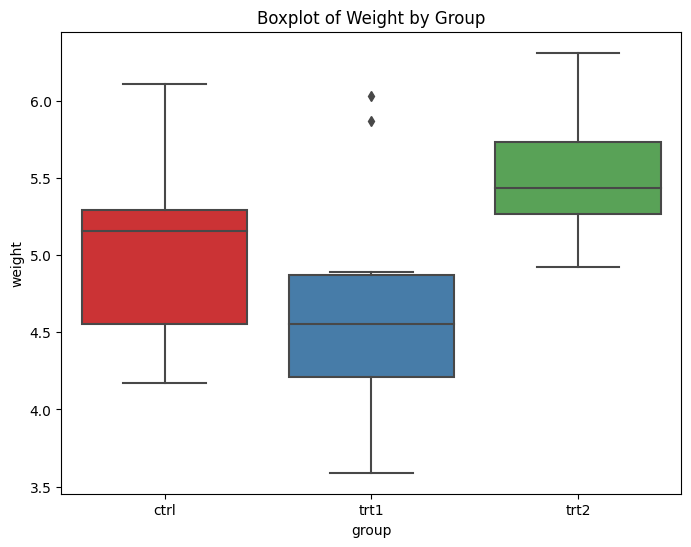

In [4]:
# Visual inspection with boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='group', y='weight', data=data, palette='Set1')
plt.title("Boxplot of Weight by Group")
plt.show()

##### Assumption 4: Initial Response
> The distribution for controlled (ctrl) and treatment 2 (trt2) groups does not shown any extreme values from all sample, hence no outliers observed to them visually 

> Although, the distribution portrayed in treatment 1 (trt1) group had at least two outliers as shown in the boxplot disbrition, to further assess whether the extreme values remain included to our overall dataset: 

> Response: **another phyton code will be executed that will confirm these as Outliers or not, through calculation of the Inter-Quartile Range (IQR)**

In [5]:
# Calculate IQR and identify outliers
def find_outliers(group_data):
    Q1 = group_data.quantile(0.25)
    Q3 = group_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group_data[(group_data < lower_bound) | (group_data > upper_bound)]

outliers = {}
for group in data['group'].unique():
    group_data = data[data['group'] == group]['weight']
    outliers[group] = find_outliers(group_data)

# Displaying outliers
for group, outlier_values in outliers.items():
    if outlier_values.empty:
        print(f"Group '{group}': No outliers")
    else:
        print(f"Group '{group}': Outliers - {', '.join(map(str, outlier_values.values))}")


Group 'ctrl': No outliers
Group 'trt1': Outliers - 5.87, 6.03
Group 'trt2': No outliers


##### Assumption 4: Final Response

> Reponse: To proceed, **we’ll remove the two outliers** `trt1 == 5.87 or trt == 6.03` from the dataset and then recreate the boxplot to visualize the data without them.

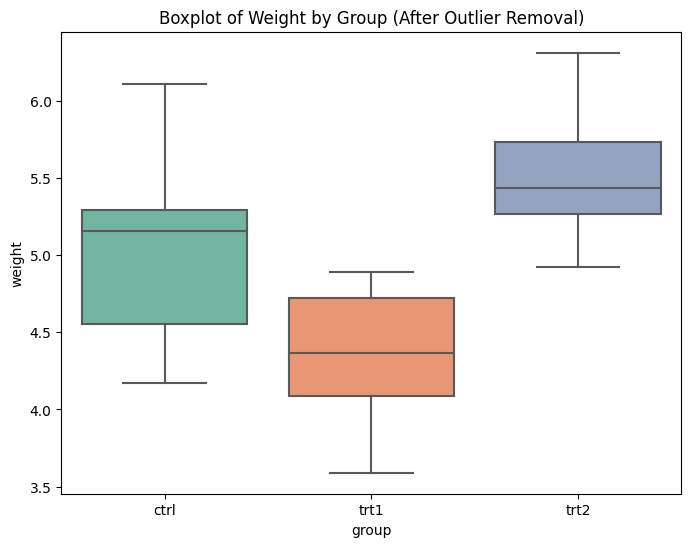

In [6]:
# Remove outliers in 'trt1' group
data_no_outliers = data[~((data['group'] == 'trt1') & (data['weight'].isin([5.87, 6.03])))]

plt.figure(figsize=(8, 6))
sns.boxplot(x='group', y='weight', data=data_no_outliers, palette='Set2')
plt.title("Boxplot of Weight by Group (After Outlier Removal)")
plt.show()

5. Assumption #5: Your dependent variable should be approximately normally distributed for each group of the independent variable.

> Response: We will utilize **Shapiro-Wilk Tests** to determine the Normality of each Independent Group

In [7]:
# Shapiro-Wilk test for each group
groups = data['group'].unique()
for group in groups:
    stat, p = stats.shapiro(data[data['group'] == group]['weight'])
    print(f'Shapiro-Wilk test for {group}: W={stat:.3f}, p={p:.3f}')


Shapiro-Wilk test for ctrl: W=0.957, p=0.747
Shapiro-Wilk test for trt1: W=0.930, p=0.452
Shapiro-Wilk test for trt2: W=0.941, p=0.564


##### Basis for Assumption 5
Basis for Interpretation:

> If $𝑝 > 0.05$ then we are failed to reject $H_0$ Null Hypothesis, suggesting no significant deviation to say that each groups is not normally distributed

> Response: Since the p-values for all three groups are above 0.05, we do not have enough evidence to conclude that any group deviates from normality. **Therefore, the assumption of normality is reasonably met for each group in this ANOVA analysis.**

6. Assumption #6. You have homogeneity of variances (i.e., the variance of the dependent variable is equal in each group of your independent variable).

> Response: We will utilize **Lavene Tests** to determine the Normality of each Independent Group

In [8]:
# Levene's Test for homogeneity of variances
stat, p = stats.levene(data[data['group'] == 'ctrl']['weight'],
                       data[data['group'] == 'trt1']['weight'],
                       data[data['group'] == 'trt2']['weight'])
print(f"Levene’s test for homogeneity of variances: W={stat:.3f}, p={p:.3f}")

Levene’s test for homogeneity of variances: W=1.119, p=0.341


##### Basis for Assumption 6
Basis for Interpretation:

> If $𝑝 > 0.05$ then we are failed to reject $H_0$ Null Hypothesis, suggesting we can assume the similarity or homogeneity of variances

> Response: With a p-value of $0.341$, which is greater than $0.05$, we fail to reject the null hypothesis. This suggests that the variances across `ctrl`, `trt1`, and `trt2` are not significantly different, **satisfying the homogeneity of variances assumption for ANOVA.**

### Dataset `PlantGrowth.csv` and the Problem (Part 2)
> The primary objective of this study is to determine whether the average weight of plants varies significantly across these treatment groups. 

> The independent variable, **group**, has three levels (`ctrl`, `trt1`, `trt2`), representing different treatments administered to the plants. The dependent variable, **weight**, represents the final weight measurement of each plant.

### Step 4: Perform One-Way ANOVA
#### Step 4.1: Null ${H_0}$ and Alternative Hypotheses ${H_A}$ as Basis for One-Way ANOVA Testing

**Null Hypothesis:**
> All independent group's {`ctrl`,`trt1`,`trt2`} population means are equal that is $µ_{ctrl} = µ_{trt1} = µ_{trt2}$

**Alternative Hypothesis:**
> At least one group population mean is different which is not all $µ_{i}$ are equal

#### Step 4.2: Basis for ANOVA test Result Intepretation:**

**F-Value {F}:**
> It indicates the ratio of the variance between the group means to the variance within the groups. A higher F-value suggests a greater difference between group means relative to the variability within groups.

**p-Value {p}:**
> Will be utilized to determine whether the observed F-value is statistically significant. If the p-value is less than the significance level (commonly set at 0.05), we reject the null hypothesis.

In [9]:
# Conduct one-way ANOVA
anova_result = stats.f_oneway(data[data['group'] == 'ctrl']['weight'],
                              data[data['group'] == 'trt1']['weight'],
                              data[data['group'] == 'trt2']['weight'])
print(f"ANOVA result: F={anova_result.statistic:.3f}, p={anova_result.pvalue:.3f}")

ANOVA result: F=4.846, p=0.016


#### Step 4.3 Interpretation to the One-Way ANOVA Result:
>Since the p-value (0.016) is less than 0.05, **we reject the null hypothesis**. This indicates that according to $H_A$, **there is a statistically significant difference in mean weight between at least two of the treatment groups.** Thus, the data suggests that the type of treatment administered to the plants has a significant effect on their growth, as measured by weight.

### Step 5: Post Hoc Analysis (Tukey's HSD Test)
> To determine which some of the independent group's population means different from the rests we will established POST HOC ANALYSIS which is can be applicable to utilized if and only if the dataset shown that the $H_A$ for ONE-WAY ANOVA satisfies the given dataset.

In [11]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Tukey HSD post hoc test
tukey = pairwise_tukeyhsd(data['weight'], data['group'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  ctrl   trt1   -0.371 0.3909 -1.0622 0.3202  False
  ctrl   trt2    0.494  0.198 -0.1972 1.1852  False
  trt1   trt2    0.865  0.012  0.1738 1.5562   True
---------------------------------------------------


### Step 6: Report and Conclusion
> The Tukey HSD results show that only the comparison between `trt1` and `trt2` yields a statistically significant difference in plant weight. This suggests that treatment 2 had a different effect on plant growth compared to treatment 1. 

> However, the control group does not significantly differ from either treatment group, indicating that treatment 2 is distinctively different only from treatment 1 in its impact on plant weight.

### References:
Bevans, R. (2020). One-way ANOVA | When and How to Use It (With Examples). Scribbr. Retrieved November 3, 2024, from https://www.scribbr.com/statistics/one-way-anova/

Fein, E. C., Gilmour, J., Machin, T., & Hendry, L. (2022, June 16). Section 6.2: One-Way ANOVA Assumptions, Interpretation, and Write up. Pressbooks. https://usq.pressbooks.pub/statisticsforresearchstudents/chapter/one-way-anova-assumptions/